In [1]:
import numpy as np
import pandas as pd

from tqdm import tqdm
from pathlib import Path

from utils.data import get_dataset_iterator, log_returns
from utils.metrics import MAPE, WAPE, MAE
from utils.synth_eval import eval_sim

import torch
from torch import nn

In [2]:
class SpectralFilter(nn.Module):
    """
    Spectral Filter torch module
    >> attributes <<
    :d: number of input dimensions
    :k: dimension of split in the input space
    :FFT: number of FFT components
    :hidden: number of hidden units in the spectral filter layer
    :flip: boolean indicator on whether to flip the split dimensions
    :RNN: boolean indicator on whether to use an RNN in spectral filtering
    """
    def __init__(self, d, k, FFT, hidden, flip=False, RNN=False):
        super().__init__()
        self.d, self.k = d, k
        if FFT:
            self.out_size = self.d - self.k + 1
            self.pz_size = self.d + 1
            self.in_size = self.k
        else:
            self.out_size = self.d - self.k
            self.pz_size = self.d
            self.in_size = self.k

        if flip:
            self.in_size, self.out_size = self.out_size, self.in_size

        self.sig_net = nn.Sequential(  # RNN(mode="RNN", HIDDEN_UNITS=20, INPUT_SIZE=1,),
            nn.Linear(self.in_size, hidden),
            nn.Sigmoid(),  # nn.LeakyReLU(),
            nn.Linear(hidden, hidden),
            nn.Sigmoid(),  # nn.Tanh(),
            nn.Linear(hidden, self.out_size),
        )

        self.mu_net = nn.Sequential(  # RNN(mode="RNN", HIDDEN_UNITS=20, INPUT_SIZE=1,),
            nn.Linear(self.in_size, hidden),
            nn.Sigmoid(),  # nn.LeakyReLU(),
            nn.Linear(hidden, hidden),
            nn.Sigmoid(),  # nn.Tanh(),
            nn.Linear(hidden, self.out_size),
        )

        base_mu, base_cov = torch.zeros(self.pz_size), torch.eye(self.pz_size)
        self.base_dist = torch.distributions.MultivariateNormal(base_mu, base_cov)

    def forward(self, x, flip=False):
        """
           Similar to RealNVP, see:
           Dinh, Laurent, Jascha Sohl-Dickstein, and Samy Bengio. 
           "Density estimation using real nvp." arXiv preprint arXiv:1605.08803 (2016).
        """
        x1, x2 = x[:, : self.k], x[:, self.k :]

        if flip:
            x2, x1 = x1, x2

        # forward
        sig = self.sig_net(x1).view(-1, self.out_size)
        z1, z2 = x1, x2 * torch.exp(sig) + self.mu_net(x1).view(-1, self.out_size)

        if flip:
            z2, z1 = z1, z2

        z_hat = torch.cat([z1, z2], dim=-1)

        log_pz = self.base_dist.log_prob(z_hat)
        log_jacob = sig.sum(-1)

        return z_hat, log_pz, log_jacob

    def inverse(self, Z, flip=False):
        z1, z2 = Z[:, : self.k], Z[:, self.k :]

        if flip:
            z2, z1 = z1, z2
        x1 = z1

        sig_in = self.sig_net(z1).view(-1, self.out_size)
        x2 = (z2 - self.mu_net(z1).view(-1, self.out_size)) * torch.exp(-sig_in)

        if flip:
            x2, x1 = x1, x2

        return torch.cat([x1, x2], -1)


def flip(x, dim):
    """flipping helper
       Takes a vector as an input, then flips its elements from left to right
       :x: input vector of size N x 1
       :dim: splitting dimension
        
    """
    xsize = x.size()
    dim = x.dim() + dim if dim < 0 else dim
    x = x.view(- 1, *xsize[dim:])
    x = x.view(x.size(0), x.size(1), -1)[
        :, getattr(torch.arange(x.size(1) - 1, -1, -1), ("cpu", "cuda")[x.is_cuda])().long(), :
    ]
    return x.view(xsize)


def reconstruct_DFT(x, component="real"):
    """prepares input to the DFT inverse
       Takes a cropped frequency and creates a symmetric or anti-symmetric mirror of it before applying inverse DFT
    """
    if component == "real":
        x_rec = torch.cat([x[0, :], flip(x[0, :], dim=0)[1:]], dim=0)
    elif component == "imag":
        x_rec = torch.cat([x[1, :], -1 * flip(x[1, :], dim=0)[1:]], dim=0)
    return x_rec


class DFT(nn.Module):
    """
    Discrete Fourier Transform (DFT) torch module
    >> attributes <<
    :N_fft: size of the DFT transform, conventionally set to length of the input time-series or a fixed 
            number of desired spectral components
    :crop_size: always equals to the size of non-redundant frequency components, i.e. N_fft / 2 since we deal with
                real-valued inputs, then the DFT is symmetric around 0 and half of the spectral components are redundant
    :base_dist: base distribution of the flow, always defined as a multi-variate normal distribution
    """
    def __init__(self, N_fft=100):
        super(DFT, self).__init__()
        self.N_fft = N_fft
        self.crop_size = int(self.N_fft / 2) + 1
        base_mu, base_cov = torch.zeros(self.crop_size * 2), torch.eye(self.crop_size * 2)
        self.base_dist = torch.distributions.MultivariateNormal(base_mu, base_cov)

    def forward(self, x):
        """forward steps
        Step 1: Convert the input vector to numpy format
        Step 2: Apply FFT in numpy with FFTshift to center the spectrum around 0
        Step 3: Crop the spectrum by removing half of the real and imaginary components. Note that the FFT output size 
                is 2 * N_fft because the DFT output is complex-valued rather than real-valued. After cropping, the size 
                remains N_fft, similar to the input time-domain signal. In this step we also normalize the spectrum by N_fft
        Step 4: Convert spectrum back to torch tensor format
        Step 5: Compute the flow likelihood and Jacobean. Because DFT is a Vandermonde linear transform, Log-Jacob-Det = 0
        """
        if len(x.shape) == 1:
            x = x.reshape((1, -1))

        x_numpy = x.detach().float()
        X_fft = [np.fft.fftshift(np.fft.fft(x_numpy[k, :])) for k in range(x.shape[0])]
        X_fft_train = np.array(
            [
                np.array(
                    [np.real(X_fft[k])[: self.crop_size] / self.N_fft, np.imag(X_fft[k])[: self.crop_size] / self.N_fft]
                )
                for k in range(len(X_fft))
            ]
        )
        x_fft = torch.from_numpy(X_fft_train).float()

        log_pz = self.base_dist.log_prob(x_fft.view(-1, x_fft.shape[1] * x_fft.shape[2]))
        log_jacob = 0

        return x_fft, log_pz, log_jacob

    def inverse(self, x):
        """Inverse steps
        Step 1: Convert the input vector to numpy format with size NUM_SAMPLES x 2 x N_fft
                Second dimension indexes the real and imaginary components.
        Step 2: Apply FFT in numpy with FFTshift to center the spectrum around 0
        Step 3: Crop the spectrum by removing half of the real and imaginary components. Note that the FFT output size 
                is 2 * N_fft because the DFT output is complex-valued rather than real-valued. After cropping, the size 
                remains N_fft, similar to the input time-domain signal. In this step we also normalize the spectrum by N_fft
        Step 4: Convert spectrum back to torch tensor format
        Step 5: Compute the flow likelihood and Jacobean. Because DFT is a Vandermonde linear transform, Log-Jacob-Det = 0
        """
        x_numpy = x.view((-1, 2, self.crop_size))
        x_numpy_r = [
            reconstruct_DFT(x_numpy[u, :, :], component="real").detach().numpy() for u in range(x_numpy.shape[0])
        ]
        x_numpy_i = [
            reconstruct_DFT(x_numpy[u, :, :], component="imag").detach().numpy() for u in range(x_numpy.shape[0])
        ]
        x_ifft = [
            self.N_fft * np.real(np.fft.ifft(np.fft.ifftshift(x_numpy_r[u] + 1j * x_numpy_i[u])))
            for u in range(x_numpy.shape[0])
        ]
        x_ifft_out = torch.from_numpy(np.array(x_ifft)).float()
        return x_ifft_out


class FourierFlow(nn.Module):
    def __init__(self, hidden, fft_size, n_flows, FFT=True, flip=True, normalize=False):
        super().__init__()
        self.d = fft_size
        self.k = int(fft_size / 2) + 1
        self.fft_size = fft_size
        self.FFT = FFT
        self.normalize = normalize

        if flip:
            self.flips = [True if i % 2 else False for i in range(n_flows)]
        else:
            self.flips = [False for i in range(n_flows)]

        self.bijectors = nn.ModuleList(
            [SpectralFilter(self.d, self.k, self.FFT, hidden=hidden, flip=self.flips[_]) for _ in range(n_flows)]
        )

        self.FourierTransform = DFT(N_fft=self.fft_size)

    def forward(self, x):
        if self.FFT:
            x = self.FourierTransform(x)[0]
            if self.normalize:
                x = (x - self.fft_mean) / self.fft_std
            x = x.view(-1, self.d + 1)

        log_jacobs = []
        for bijector, f in zip(self.bijectors, self.flips):
            x, log_pz, lj = bijector(x, flip=f)
            log_jacobs.append(lj)

        return x, log_pz, sum(log_jacobs)

    def inverse(self, z):
        for bijector, f in zip(reversed(self.bijectors), reversed(self.flips)):
            z = bijector.inverse(z, flip=f)

        if self.FFT:
            if self.normalize:
                z = z * self.fft_std.view(-1, self.d + 1) + self.fft_mean.view(-1, self.d + 1)
            z = self.FourierTransform.inverse(z)

        return z.detach().numpy()

    def fit(self, X, epochs=500, batch_size=128, learning_rate=1e-3, display_step=100):
        X_train = torch.from_numpy(np.array(X)).float()

        # for normalizing the spectral transforms
        X_train_spectral = self.FourierTransform(X_train)[0]
        self.fft_mean = torch.mean(X_train_spectral, dim=0)
        self.fft_std = torch.std(X_train_spectral, dim=0)
    
        self.d = X_train.shape[1]
        self.k = int(np.floor(X_train.shape[1] / 2))

        optim = torch.optim.Adam(self.parameters(), lr=learning_rate)
        scheduler = torch.optim.lr_scheduler.ExponentialLR(optim, 0.999)

        losses = []
        all_epochs = int(np.floor(epochs / display_step))

        for step in range(epochs):
            optim.zero_grad()

            z, log_pz, log_jacob = self(X_train)
            loss = (-log_pz - log_jacob).mean()
            losses.append(loss.detach().numpy())

            loss.backward()
            optim.step()
            scheduler.step()

            if ((step % display_step) == 0) | (step == epochs - 1):
                current_epochs = int(np.floor((step + 1) / display_step))
                remaining_epochs = int(all_epochs - current_epochs)

                progress_signs = current_epochs * "|" + remaining_epochs * "-"
                display_string = "step: %d \t/ %d \t" + progress_signs + "\tloss: %.3f"

                print(display_string % (step, epochs, loss))

            if step == epochs - 1:
                print("Finished training!")

        return losses

    def sample(self, n_samples):
        if self.FFT:
            mu, cov = torch.zeros(self.d + 1), torch.eye(self.d + 1)
        else:
            mu, cov = torch.zeros(self.d), torch.eye(self.d)

        p_Z = torch.distributions.MultivariateNormal(mu, cov)
        z = p_Z.rsample(sample_shape=(n_samples,))
        X_sample = self.inverse(z)
        return X_sample

->exps

In [3]:
class SinFlow(nn.Module):
    def __init__(self, hidden, fft_size, n_flows, flip=True, normalize=False):
        super().__init__()
        self.d = fft_size
        self.k = int(fft_size / 2) + 1
        self.fft_size = fft_size
        self.normalize = normalize

        if flip:
            self.flips = [True if i % 2 else False for i in range(n_flows)]
        else:
            self.flips = [False for i in range(n_flows)]

        self.bijectors = nn.ModuleList(
            [SpectralFilter(self.d, self.k, False, hidden=hidden, flip=self.flips[_]) for _ in range(n_flows)]
        )

    def forward(self, x):
        x = torch.sin(x)
        log_jacobs = []
        for bijector, f in zip(self.bijectors, self.flips):
            x, log_pz, lj = bijector(x, flip=f)
            log_jacobs.append(lj)

        return x, log_pz, sum(log_jacobs)

    def inverse(self, z):
        for bijector, f in zip(reversed(self.bijectors), reversed(self.flips)):
            z = bijector.inverse(z, flip=f)
        z = torch.arcsin(z.clip(- 1, 1))
        return z.detach().numpy()

    def fit(self, X, epochs=500, batch_size=128, learning_rate=1e-3, display_step=100):
        X_train = torch.from_numpy(np.array(X)).float()
   
        self.d = X_train.shape[1]
        self.k = int(np.floor(X_train.shape[1] / 2))

        optim = torch.optim.Adam(self.parameters(), lr=learning_rate)
        scheduler = torch.optim.lr_scheduler.ExponentialLR(optim, 0.999)

        losses = []
        all_epochs = int(np.floor(epochs / display_step))

        for step in range(epochs):
            optim.zero_grad()

            z, log_pz, log_jacob = self(X_train)
            loss = (-log_pz - log_jacob).mean()
            losses.append(loss.detach().numpy())

            loss.backward()
            optim.step()
            scheduler.step()
                
        return losses

    def sample(self, n_samples):
        mu, cov = torch.zeros(self.d), torch.eye(self.d)
        p_Z = torch.distributions.MultivariateNormal(mu, cov)
        z = p_Z.rsample(sample_shape=(n_samples,))
        X_sample = self.inverse(z)
        return X_sample

In [4]:
hsm_dataset_path = Path("data/huge_stock_market_dataset/")
solar_energy_dataset_path = Path("data/solar_energy/")
fuel_prices_dataset_path = Path("data/fuel_prices/")
passengers_dataset_path = Path("data/air_passengers/")
models_dir = Path("models/")
results_dir = Path("results")

device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
print(device)

val_size = 0.0
test_size = 0.0

T = 127
n_samples = 800 * 127  # number of samples generated by QuantGAN

def gen_model(model_init, model_name, dataset_name, dataset_path):
    ts_iterator = get_dataset_iterator(dataset_name, dataset_path)

    for ts_index, time_series in tqdm(enumerate(ts_iterator)):
        # print(f"Time Series #{ts_index}")
        
        train_ts = log_returns(time_series[:10_000] + 1e-9)
        train_ts = train_ts[:(len(train_ts) // 4 * 4 + 1 if len(train_ts) % 4 > 0 else len(train_ts) - 3)]

        torch.random.manual_seed(0)
        model = model_init(hidden=200, fft_size=len(train_ts), n_flows=10)

        losses = model.fit(train_ts.values.reshape(1, - 1), epochs=(50 if len(train_ts) < 3_000 else 10), batch_size=128, 
                                learning_rate=1e-3, display_step=50)

        synth_data = model.sample(n_samples // len(train_ts))
        synthetic_path = dataset_path / f"synthetic/{model_name}/"
        if not synthetic_path.exists(): synthetic_path.mkdir()
        np.save(synthetic_path / f"selected{ts_index}.npy", synth_data)

        del train_ts, synth_data, model, losses

cuda:0


SinFlow

In [19]:
for dataset_ind, (dataset_name, dataset_path) in enumerate(
    (("hsm", hsm_dataset_path),
    ("se", solar_energy_dataset_path),
    ("fp", fuel_prices_dataset_path),
    ("ap", passengers_dataset_path))
):
    gen_model(SinFlow, "SinFlow", dataset_name, dataset_path)

100it [11:54,  7.14s/it]
10it [23:48, 142.88s/it]
8it [00:24,  3.03s/it]
99it [03:35,  2.18s/it]


In [6]:
eval_sim(("hsm", "se", "fp", "ap"), (hsm_dataset_path, solar_energy_dataset_path, fuel_prices_dataset_path, passengers_dataset_path),
     "RealNVP", save=True, results_dir=results_dir)

processing hsm dataset


100it [00:07, 13.15it/s]


processing se dataset


10it [00:01,  9.00it/s]


processing fp dataset


8it [00:00, 12.71it/s]


processing ap dataset


99it [00:52,  1.88it/s]


defaultdict(dict,
            {'hsm': {'kl_div': 0.008527711905854433,
              'kstest_pval': 0.025552798607284335},
             'se': {'kl_div': 0.02127043801348618, 'kstest_pval': 0.0},
             'fp': {'kl_div': 0.026416774229484054,
              'kstest_pval': 0.016930916303330826},
             'ap': {'kl_div': 0.12064409262307832,
              'kstest_pval': 0.12095015506943128}})

In [20]:
eval_sim(("hsm", "se", "fp", "ap"), (hsm_dataset_path, solar_energy_dataset_path, fuel_prices_dataset_path, passengers_dataset_path),
     "FourierFlow", save=True, results_dir=results_dir)

processing hsm dataset


100it [00:07, 12.86it/s]


processing se dataset


10it [00:01,  9.59it/s]


processing fp dataset


8it [00:00, 13.78it/s]


processing ap dataset


99it [00:54,  1.82it/s]


defaultdict(dict,
            {'hsm': {'kl_div': 0.004406467891625162,
              'kstest_pval': 0.008581871834103695},
             'se': {'kl_div': 0.0004964904860448611, 'kstest_pval': 0.0},
             'fp': {'kl_div': 0.00924879087459686,
              'kstest_pval': 0.014328988316370375},
             'ap': {'kl_div': 0.007864740906357463,
              'kstest_pval': 0.04402944541555635}})

In [21]:
eval_sim(("hsm", "se", "fp", "ap"), (hsm_dataset_path, solar_energy_dataset_path, fuel_prices_dataset_path, passengers_dataset_path),
     "SinFlow", save=True, results_dir=results_dir)

processing hsm dataset


100it [00:07, 13.58it/s]


processing se dataset


10it [00:00, 10.72it/s]


processing fp dataset


8it [00:00, 14.07it/s]


processing ap dataset


99it [00:53,  1.86it/s]


defaultdict(dict,
            {'hsm': {'kl_div': 0.00839956473508188,
              'kstest_pval': 0.01983085388894746},
             'se': {'kl_div': 0.0101104444224767, 'kstest_pval': 5e-324},
             'fp': {'kl_div': 0.021202545100562763,
              'kstest_pval': 0.03927719817124939},
             'ap': {'kl_div': 0.08843043297987675,
              'kstest_pval': 0.018949085558300112}})

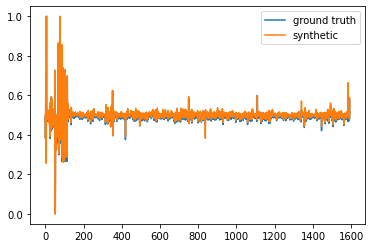

In [8]:
ind = 44
iterator = get_dataset_iterator("hsm", hsm_dataset_path)
for _ in range(ind): next(iterator)
gt = log_returns(next(iterator)).values.flatten()
gt = gt[:(len(gt) // 4 * 4 + 1 if len(gt) % 4 > 0 else len(gt) - 3)]
min_max_norm = lambda x: (x - x.min()) / (x.max() - x.min())
gt = min_max_norm(gt) + 1e-9
st = min_max_norm(np.load(hsm_dataset_path / f"synthetic/SinFlow/selected{ind}.npy")[0])
import matplotlib.pyplot as plt
plt.plot(gt)
plt.plot(st)
plt.legend(["ground truth", "synthetic"])
plt.show()

In [5]:
class RevSinFlow(nn.Module):
    def __init__(self, hidden, fft_size, n_flows, flip=True, normalize=False):
        super().__init__()
        self.d = fft_size
        self.k = int(fft_size / 2) + 1
        self.fft_size = fft_size
        self.normalize = normalize

        if flip:
            self.flips = [True if i % 2 else False for i in range(n_flows)]
        else:
            self.flips = [False for i in range(n_flows)]

        self.bijectors = nn.ModuleList(
            [SpectralFilter(self.d, self.k, False, hidden=hidden, flip=self.flips[_]) for _ in range(n_flows)]
        )

    def forward(self, x):
        x = torch.arcsin((x).clip(- 1, 1))
        log_jacobs = []
        for bijector, f in zip(self.bijectors, self.flips):
            x, log_pz, lj = bijector(x, flip=f)
            log_jacobs.append(lj)

        return x, log_pz, sum(log_jacobs)

    def inverse(self, z):
        for bijector, f in zip(reversed(self.bijectors), reversed(self.flips)):
            z = bijector.inverse(z, flip=f)
        z = torch.sin(z)
        return z.detach().numpy()

    def fit(self, X, epochs=500, batch_size=128, learning_rate=1e-3, display_step=100):
        X_train = torch.from_numpy(np.array(X)).float()
   
        self.d = X_train.shape[1]
        self.k = int(np.floor(X_train.shape[1] / 2))

        optim = torch.optim.Adam(self.parameters(), lr=learning_rate)
        scheduler = torch.optim.lr_scheduler.ExponentialLR(optim, 0.999)

        losses = []
        all_epochs = int(np.floor(epochs / display_step))

        for step in range(epochs):
            optim.zero_grad()

            z, log_pz, log_jacob = self(X_train)
            loss = (-log_pz - log_jacob).mean()
            losses.append(loss.detach().numpy())

            loss.backward()
            optim.step()
            scheduler.step()
                
        return losses

    def sample(self, n_samples):
        mu, cov = torch.zeros(self.d), torch.eye(self.d)
        p_Z = torch.distributions.MultivariateNormal(mu, cov)
        z = p_Z.rsample(sample_shape=(n_samples,))
        X_sample = self.inverse(z)
        return X_sample

In [24]:
for dataset_ind, (dataset_name, dataset_path) in enumerate(
    (("hsm", hsm_dataset_path),
    ("se", solar_energy_dataset_path),
    ("fp", fuel_prices_dataset_path),
    ("ap", passengers_dataset_path))
):
    gen_model(RevSinFlow, "RevSinFlow", dataset_name, dataset_path)

100it [11:52,  7.13s/it]
10it [24:46, 148.68s/it]
8it [00:33,  4.22s/it]
99it [03:38,  2.21s/it]


In [25]:
eval_sim(("hsm", "se", "fp", "ap"), (hsm_dataset_path, solar_energy_dataset_path, fuel_prices_dataset_path, passengers_dataset_path),
     "RevSinFlow", save=True, results_dir=results_dir)

processing hsm dataset


100it [00:07, 13.99it/s]


processing se dataset


10it [00:00, 11.69it/s]


processing fp dataset


8it [00:00, 14.58it/s]


processing ap dataset


99it [00:54,  1.80it/s]


defaultdict(dict,
            {'hsm': {'kl_div': 0.009456554844411989,
              'kstest_pval': 0.020685500533010583},
             'se': {'kl_div': 0.00892809028706798, 'kstest_pval': 5e-324},
             'fp': {'kl_div': 0.014265592724820673,
              'kstest_pval': 0.03567761220525049},
             'ap': {'kl_div': 0.054494015595570794,
              'kstest_pval': 0.003526152353464199}})

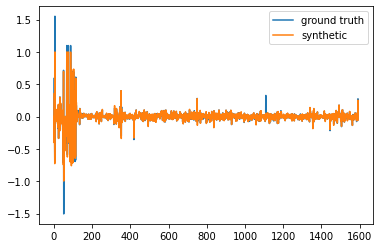

In [26]:
ind = 44
iterator = get_dataset_iterator("hsm", hsm_dataset_path)
for _ in range(ind): next(iterator)
gt = log_returns(next(iterator)).values.flatten()
gt = gt[:(len(gt) // 4 * 4 + 1 if len(gt) % 4 > 0 else len(gt) - 3)]
min_max_norm = lambda x: (x - x.min()) / (x.max() - x.min())
# gt = min_max_norm(gt) + 1e-9
# st = min_max_norm(np.load(hsm_dataset_path / f"synthetic/RevSinFlow/selected{ind}.npy")[0])
st = np.load(hsm_dataset_path / f"synthetic/RevSinFlow/selected{ind}.npy")[0]
import matplotlib.pyplot as plt
plt.plot(gt)
plt.plot(st)
plt.legend(["ground truth", "synthetic"])
plt.show()

With QuantGAN discriminator

In [8]:
from utils.dl import QuantGAN_Discriminator

In [5]:
class QuantFlow(nn.Module):
    def __init__(self, hidden, fft_size, n_flows, FFT=True, flip=True, normalize=False):
        super().__init__()
        self.d = fft_size
        self.k = int(fft_size / 2) + 1
        self.fft_size = fft_size
        self.FFT = FFT
        self.normalize = normalize

        if flip:
            self.flips = [True if i % 2 else False for i in range(n_flows)]
        else:
            self.flips = [False for i in range(n_flows)]

        self.bijectors = nn.ModuleList(
            [SpectralFilter(self.d, self.k, self.FFT, hidden=hidden, flip=self.flips[_]) for _ in range(n_flows)]
        )

        self.FourierTransform = DFT(N_fft=self.fft_size)

    def forward(self, x):
        if self.FFT:
            x = self.FourierTransform(x)[0]
            if self.normalize:
                x = (x - self.fft_mean) / self.fft_std
            x = x.view(-1, self.d + 1)

        log_jacobs = []
        for bijector, f in zip(self.bijectors, self.flips):
            x, log_pz, lj = bijector(x, flip=f)
            log_jacobs.append(lj)

        return x, log_pz, sum(log_jacobs)

    def inverse(self, z):
        for bijector, f in zip(reversed(self.bijectors), reversed(self.flips)):
            z = bijector.inverse(z, flip=f)

        if self.FFT:
            if self.normalize:
                z = z * self.fft_std.view(-1, self.d + 1) + self.fft_mean.view(-1, self.d + 1)
            z = self.FourierTransform.inverse(z)

        return z.detach().numpy()

    def fit(self, X, epochs=500, batch_size=128, learning_rate=1e-3, display_step=100):
        X_train = torch.from_numpy(np.array(X)).float()

        # for normalizing the spectral transforms
        X_train_spectral = self.FourierTransform(X_train)[0]
        self.fft_mean = torch.mean(X_train_spectral, dim=0)
        self.fft_std = torch.std(X_train_spectral, dim=0)
    
        self.d = X_train.shape[1]
        self.k = int(np.floor(X_train.shape[1] / 2))

        disc = QuantGAN_Discriminator(X_train.shape[1])

        optim_flow = torch.optim.Adam(self.parameters(), lr=learning_rate)
        optim_disc = torch.optim.Adam(disc.parameters(), lr=learning_rate)
        scheduler_flow = torch.optim.lr_scheduler.ExponentialLR(optim_flow, 0.999)
        scheduler_disc = torch.optim.lr_scheduler.ExponentialLR(optim_disc, 0.999)

        losses = []
        all_epochs = int(np.floor(epochs / display_step))

        for step in range(epochs):
            optim_disc.zero_grad()
            fake = torch.from_numpy(self.sample(1))
            disc_loss = - torch.mean(disc(X_train.unsqueeze(1))) + torch.mean(disc(fake.unsqueeze(1)))
            disc_loss.backward()
            optim_disc.step()
            scheduler_disc.step()

            optim_flow.zero_grad()
            z, log_pz, log_jacob = self(X_train)
            loss = (-log_pz - log_jacob).mean()
            losses.append(loss.detach().numpy())
            loss.backward()
            gen_loss = - torch.mean(disc(torch.from_numpy(self.sample(1)).unsqueeze(1))) * abs(loss.item())
            gen_loss.backward()
            optim_flow.step()
            scheduler_flow.step()

            if ((step % display_step) == 0) | (step == epochs - 1):
                current_epochs = int(np.floor((step + 1) / display_step))
                remaining_epochs = int(all_epochs - current_epochs)

                progress_signs = current_epochs * "|" + remaining_epochs * "-"
                display_string = "step: %d \t/ %d \t" + progress_signs + "\tloss: %.3f"

                print(display_string % (step, epochs, loss))

            if step == epochs - 1:
                print("Finished training!")

        return losses

    def sample(self, n_samples):
        if self.FFT:
            mu, cov = torch.zeros(self.d + 1), torch.eye(self.d + 1)
        else:
            mu, cov = torch.zeros(self.d), torch.eye(self.d)

        p_Z = torch.distributions.MultivariateNormal(mu, cov)
        z = p_Z.rsample(sample_shape=(n_samples,))
        X_sample = self.inverse(z)
        return X_sample

In [10]:
for dataset_ind, (dataset_name, dataset_path) in enumerate((
    ("hsm", hsm_dataset_path),
    # ("se", solar_energy_dataset_path),
    ("fp", fuel_prices_dataset_path),
    ("ap", passengers_dataset_path)
)):
    gen_model(QuantFlow, "QuantFlow", dataset_name, dataset_path)

0it [02:11, ?it/s]


RuntimeError: [enforce fail at ..\c10\core\CPUAllocator.cpp:75] data. DefaultCPUAllocator: not enough memory: you tried to allocate 399840016 bytes. Buy new RAM!

In [6]:
# eval_sim(("hsm", "se", "fp", "ap"), (hsm_dataset_path, solar_energy_dataset_path, fuel_prices_dataset_path, passengers_dataset_path),
eval_sim(("hsm", "fp", "ap"), (hsm_dataset_path, fuel_prices_dataset_path, passengers_dataset_path),
     "QuantFlow", save=True, results_dir=results_dir)

processing hsm dataset


100it [00:06, 14.56it/s]


processing fp dataset


8it [00:00, 15.05it/s]


processing ap dataset


99it [00:53,  1.85it/s]


defaultdict(dict,
            {'hsm': {'kl_div': 0.004388278693274113,
              'kstest_pval': 0.00792543537427461},
             'fp': {'kl_div': 0.009393894801323743,
              'kstest_pval': 0.013208117268269351},
             'ap': {'kl_div': 0.007861058434015323,
              'kstest_pval': 0.04304156027443417}})

TimeFusion

In [1]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt

from tqdm import tqdm
from pathlib import Path

from utils.data import get_dataset_iterator, log_returns
from utils.metrics import MAPE, WAPE, MAE
from utils.synth_eval import eval_sim

import torch
from torch import nn

from utils.dl import QuantGAN_TemporalBlock


hsm_dataset_path = Path("data/huge_stock_market_dataset/")
solar_energy_dataset_path = Path("data/solar_energy/")
fuel_prices_dataset_path = Path("data/fuel_prices/")
passengers_dataset_path = Path("data/air_passengers/")
models_dir = Path("models/")
results_dir = Path("results")

device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
print(device)

cuda:0


In [2]:
class DiffGen(nn.Module):
    def __init__(self):
        super().__init__()
        self.tcn = nn.ModuleList([QuantGAN_TemporalBlock(1, 80, kernel_size=1, stride=1, dilation=1, padding=0),
                                #  *[QuantGAN_TemporalBlock(80, 80, kernel_size=2, stride=1, dilation=i, padding=i) for i in [1, 2, 4, 8, 16, 32]]])
                                 *[QuantGAN_TemporalBlock(80, 80, kernel_size=2, stride=1, dilation=i, padding=i) for i in [2 ** i for i in range(14)]]])
        self.last = nn.Conv1d(80, 1, kernel_size=1, stride=1, dilation=1)

    def forward(self, x):
        skip_layers = []
        for layer in self.tcn:
            skip, x = layer(x)
            skip_layers.append(skip)
        x = self.last(x + sum(skip_layers))
        return x

100%|██████████| 10/10 [15:14<00:00, 91.41s/it]


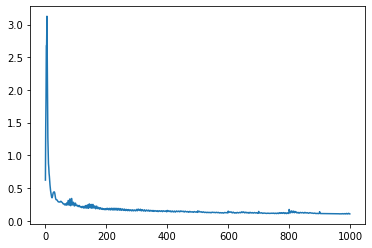

In [3]:
epochs = 10
steps_per_epoch = 100
batch_size = 128

for dataset_ind, (dataset_name, dataset_path) in enumerate(
    (("hsm", hsm_dataset_path),
    ("se", solar_energy_dataset_path),
    ("fp", fuel_prices_dataset_path),
    ("ap", passengers_dataset_path))
):
    ts_iterator = get_dataset_iterator(dataset_name, dataset_path)
    for time_series in ts_iterator:
        train = time_series.values.flatten()
        train = (train - train.mean()) / train.std()
        train_tensor = torch.from_numpy(train).float().to(device)

        torch.random.manual_seed(0)
        model = DiffGen().to(device)
        optim = torch.optim.AdamW(model.parameters(), lr=4e-4)
        losses = []

        for epoch in tqdm(range(1, epochs + 1)):
            model.train()
            X = train_tensor.repeat(batch_size, 1).unsqueeze(1)
            noise = torch.row_stack([torch.rand(1, *X.shape[1:]) for _ in range(X.shape[0])]).to(device)
            noise_level = torch.rand(X.shape).to(device)
            noise *= noise_level

            for step in range(steps_per_epoch):
                optim.zero_grad()
                y_hat = model(X + noise)
                loss = (y_hat - noise).abs().mean()
                loss.backward()
                optim.step()
                with torch.no_grad():
                    X -= y_hat
                    noise -= y_hat
                losses.append(loss.item())

        plt.plot(losses)
        
        break
    break

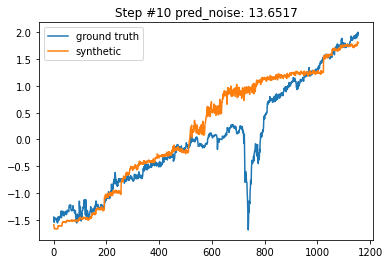

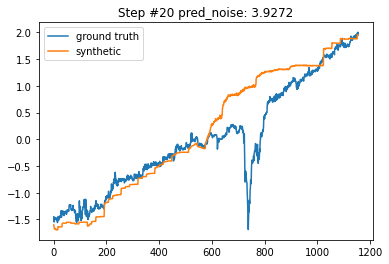

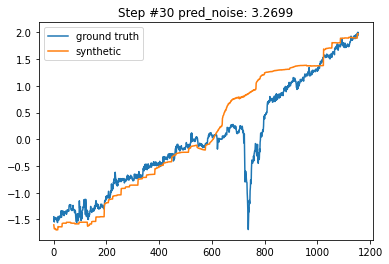

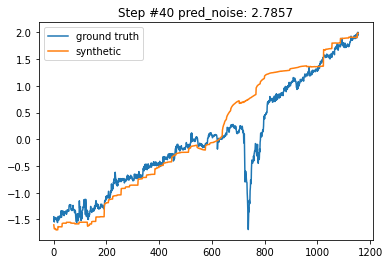

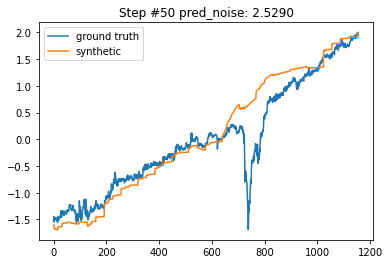

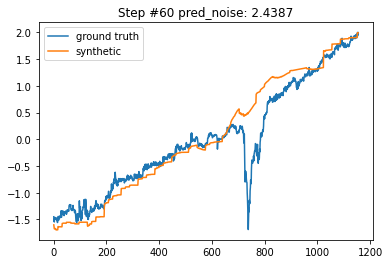

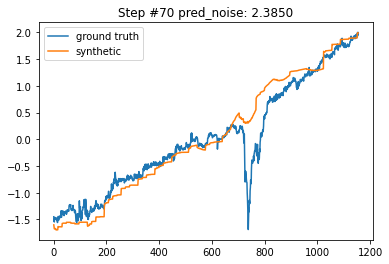

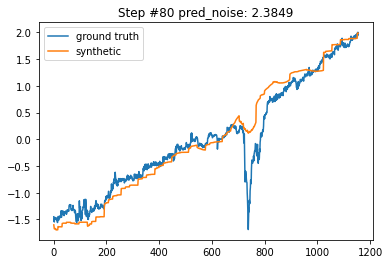

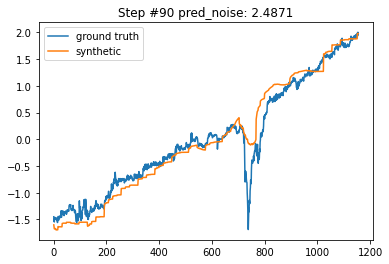

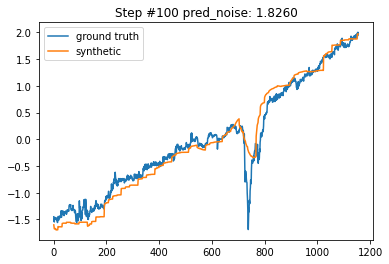

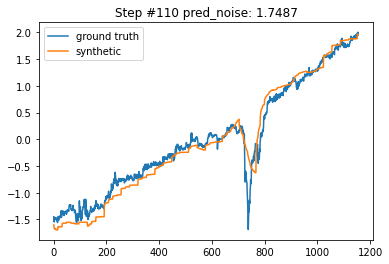

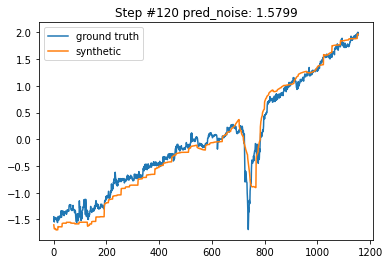

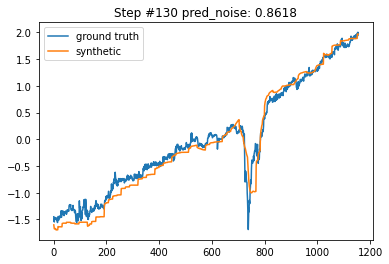

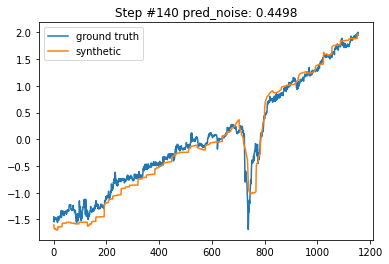

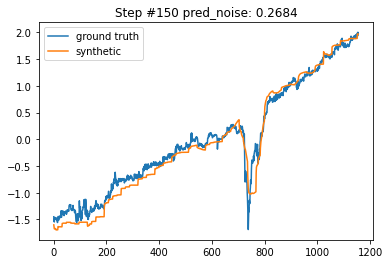

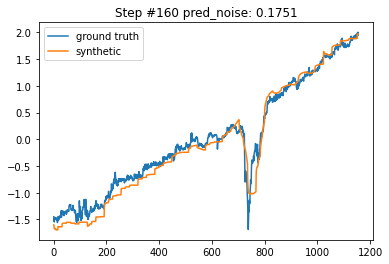

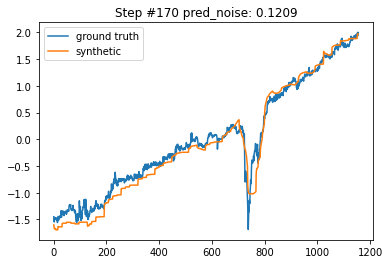

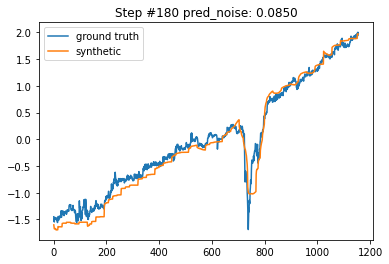

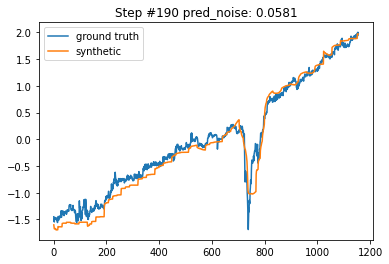

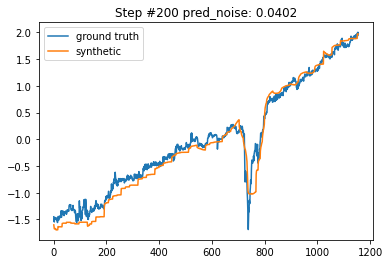

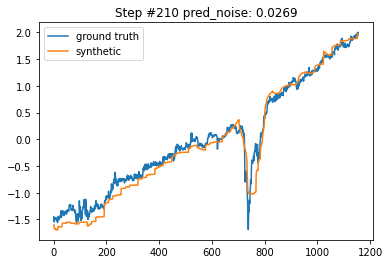

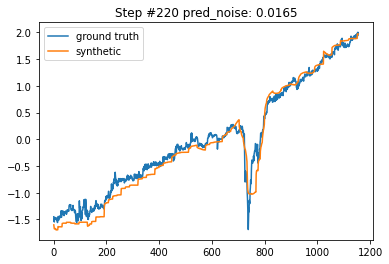

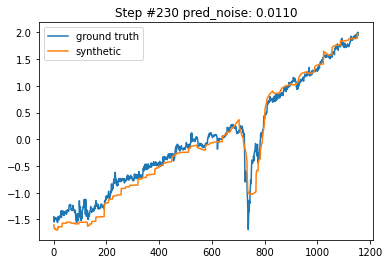

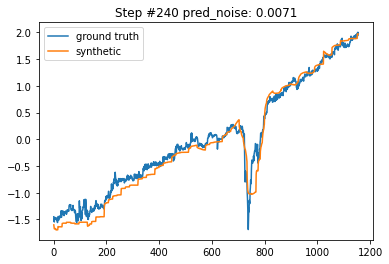

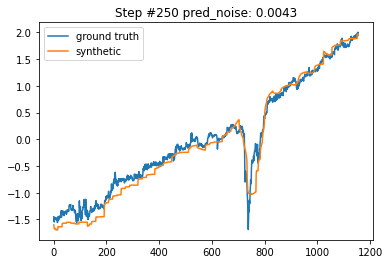

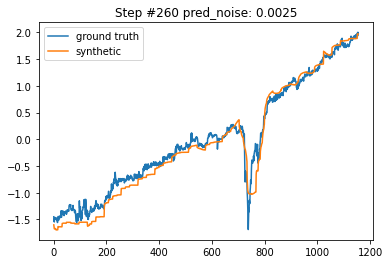

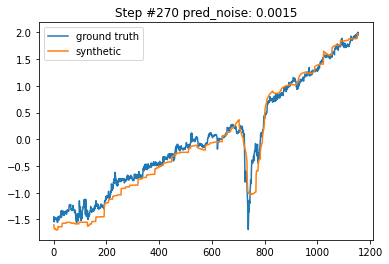

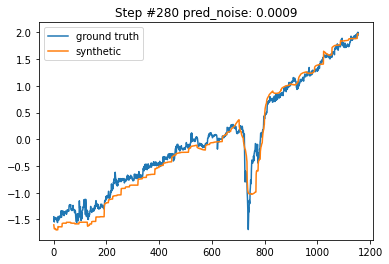

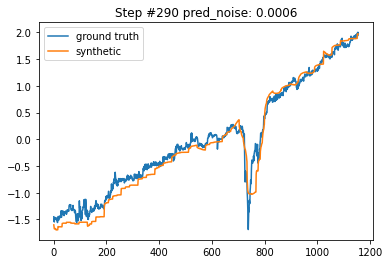

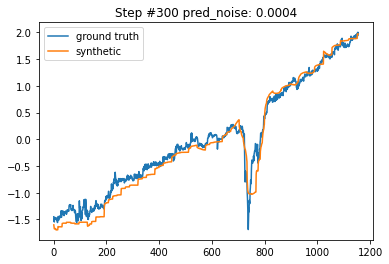

In [7]:
steps = steps_per_epoch * 3
plot_rate = steps_per_epoch // 10
with torch.no_grad():
    model.eval()
    noise = torch.rand(1, 1, len(train)).to(device)
    generated = noise
    for step in range(1, steps + 1):
        pred_noise = model(generated)
        generated -= pred_noise
        if step % plot_rate == 0:

            result = generated.detach().cpu().squeeze().numpy()
            plt.plot(train)
            plt.plot(result)
            plt.legend(["ground truth", "synthetic"])
            plt.title(f"Step #{step} pred_noise: {pred_noise.sum().item():0.4f}")
            plt.show()
# plt.plot(noise.cpu().numpy().squeeze())
# plt.plot(pred_noise.cpu().numpy().squeeze())
# plt.legend(["noise", "pred_noise"])

In [15]:
from scipy.special import kl_div

In [ ]:
class DiffGen(nn.Module):
    def __init__(self):
        super().__init__()
        self.tcn = nn.ModuleList([QuantGAN_TemporalBlock(1, 80, kernel_size=1, stride=1, dilation=1, padding=0),
                                 *[QuantGAN_TemporalBlock(80, 80, kernel_size=2, stride=1, dilation=i, padding=i)
                                        for i in [2 ** i for i in range(14)]]])
        self.last = nn.Conv1d(80, 1, kernel_size=1, stride=1, dilation=1)

    def forward(self, x):
        skip_layers = []
        for layer in self.tcn:
            skip, x = layer(x)
            skip_layers.append(skip)
        x = self.last(x + sum(skip_layers))
        return x

100%|██████████| 10/10 [20:42<00:00, 124.23s/it]


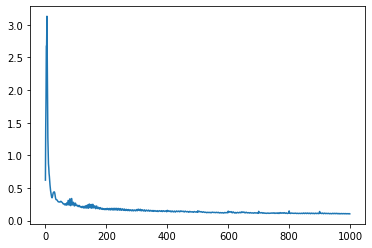

[0.025145833406430458, 0.019455734580964747, 0.010225827394992277, 0.13527382651444492, 0.013409231038654093, 0.04039276556207545, 0.020492869081831202, 0.0154398577066442, 0.0335216702277543, 0.017760316952772453]


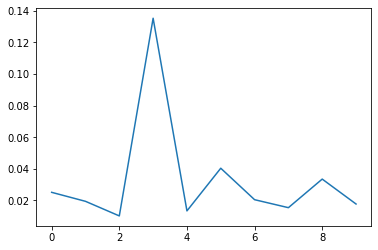

In [23]:
epochs = 10
steps_per_epoch = 100
batch_size = 128

for dataset_ind, (dataset_name, dataset_path) in enumerate(
    (("hsm", hsm_dataset_path),
    ("se", solar_energy_dataset_path),
    ("fp", fuel_prices_dataset_path),
    ("ap", passengers_dataset_path))
):
    ts_iterator = get_dataset_iterator(dataset_name, dataset_path)
    for time_series in ts_iterator:
        train = time_series.values.flatten()
        train = (train - train.mean()) / train.std()
        train_tensor = torch.from_numpy(train).float().to(device)

        torch.random.manual_seed(0)
        model = DiffGen().to(device)
        optim = torch.optim.AdamW(model.parameters(), lr=4e-4)
        losses = []
        kl_divs = []
        val_noise = torch.rand(20, 1, len(train)).to(device)

        for epoch in tqdm(range(1, epochs + 1)):
            model.train()
            X = train_tensor.repeat(batch_size, 1).unsqueeze(1)
            noise = torch.row_stack([torch.rand(1, *X.shape[1:]) for _ in range(X.shape[0])]).to(device)
            noise_level = torch.rand(X.shape).to(device)
            noise *= noise_level

            for step in range(steps_per_epoch):
                optim.zero_grad()
                y_hat = model(X + noise)
                loss = (y_hat - noise).abs().mean()
                loss.backward()
                optim.step()
                with torch.no_grad():
                    X -= y_hat
                    noise -= y_hat
                losses.append(loss.item())
            
            steps = steps_per_epoch * 3
            with torch.no_grad():
                model.eval()
                generated = val_noise
                for step in range(1, steps + 1):
                    pred_noise = model(generated)
                    generated -= pred_noise
                generated = generated.detach().cpu().numpy().squeeze()
            kl_divs.append(np.mean([np.mean([x for x in kl_div(generated[i], train) if not np.isnan(x) and not np.isinf(x)])
                                for i in range(len(generated))]))
 
        plt.plot(losses)
        plt.show()
        plt.plot(kl_divs)
        print(kl_divs)
        
        break
    break

In [30]:
class DiffGen(nn.Module):
    def __init__(self):
        super().__init__()
        self.tcn = nn.ModuleList([QuantGAN_TemporalBlock(1, 128, kernel_size=1, stride=1, dilation=1, padding=0),
                                 *[QuantGAN_TemporalBlock(128, 128, kernel_size=2, stride=1, dilation=i, padding=i)
                                        for i in [2 ** i for i in range(14)]]])
        self.last = nn.Conv1d(128, 1, kernel_size=1, stride=1, dilation=1)

    def forward(self, x):
        skip_layers = []
        for layer in self.tcn:
            skip, x = layer(x)
            skip_layers.append(skip)
        x = self.last(x + sum(skip_layers))
        return x


epochs = 10
steps_per_epoch = 100
batch_size = 128

for dataset_ind, (dataset_name, dataset_path) in enumerate(
    (("hsm", hsm_dataset_path),
    ("se", solar_energy_dataset_path),
    ("fp", fuel_prices_dataset_path),
    ("ap", passengers_dataset_path))
):
    ts_iterator = get_dataset_iterator(dataset_name, dataset_path)
    for time_series in ts_iterator:
        train = time_series.values.flatten()
        train = (train - train.mean()) / train.std()
        train_tensor = torch.from_numpy(train).float().to(device)

        torch.random.manual_seed(0)
        model = DiffGen().to(device)
        optim = torch.optim.AdamW(model.parameters(), lr=4e-4)
        losses = []
        kl_divs = []
        val_noise = torch.rand(20, 1, len(train)).to(device)

        for epoch in tqdm(range(1, epochs + 1)):
            model.train()
            X = train_tensor.repeat(batch_size, 1).unsqueeze(1)
            noise = torch.row_stack([torch.rand(1, *X.shape[1:]) for _ in range(X.shape[0])]).to(device)
            noise_level = torch.rand(X.shape).to(device)
            noise *= noise_level

            for step in range(steps_per_epoch):
                optim.zero_grad()
                y_hat = model(X + noise)
                loss = (y_hat - noise).abs().mean()
                loss.backward()
                optim.step()
                with torch.no_grad():
                    X -= y_hat
                    noise -= y_hat
                losses.append(loss.item())
            
            steps = steps_per_epoch * 3
            with torch.no_grad():
                model.eval()
                generated = val_noise
                for step in range(1, steps + 1):
                    pred_noise = model(generated)
                    generated -= pred_noise
                generated = generated.detach().cpu().numpy().squeeze()
            kl_divs.append(np.mean([np.mean([x for x in kl_div(generated[i], train) if not np.isnan(x) and not np.isinf(x)])
                                for i in range(len(generated))]))
 
        plt.plot(losses)
        plt.show()
        plt.plot(kl_divs)
        print(kl_divs)
        
        break
    break

  0%|          | 0/10 [00:01<?, ?it/s]


RuntimeError: CUDA out of memory. Tried to allocate 74.00 MiB (GPU 0; 6.00 GiB total capacity; 4.99 GiB already allocated; 0 bytes free; 5.29 GiB reserved in total by PyTorch)

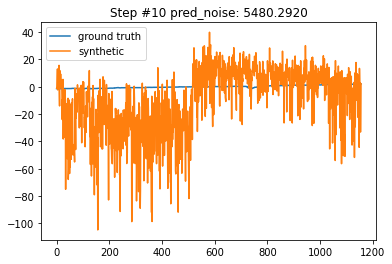

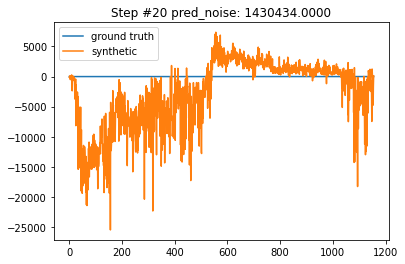

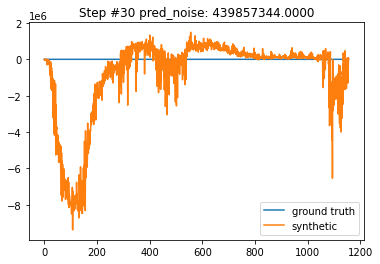

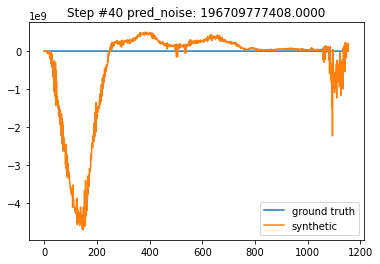

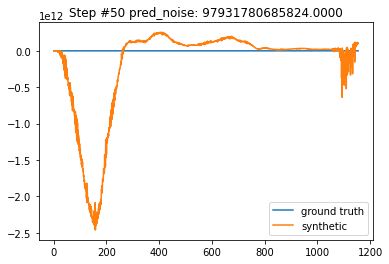

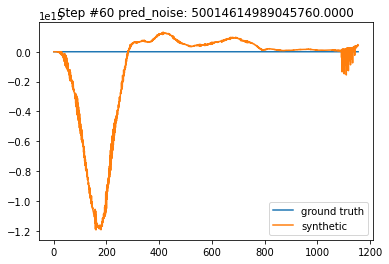

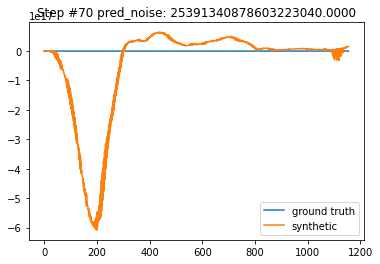

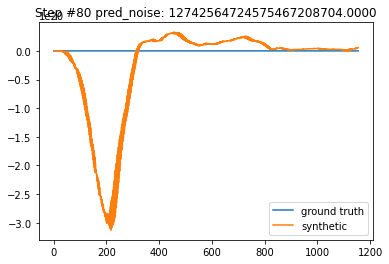

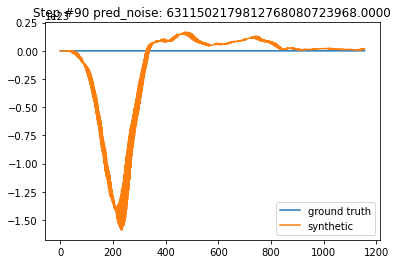

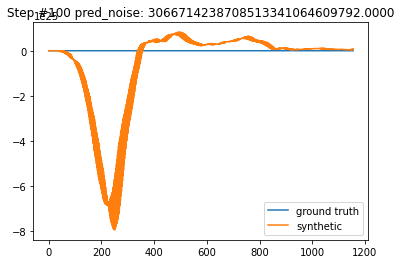

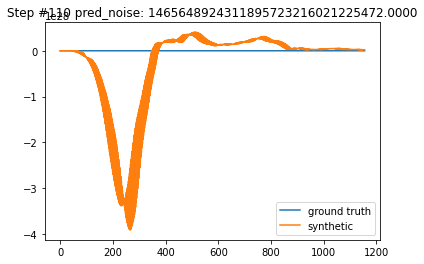

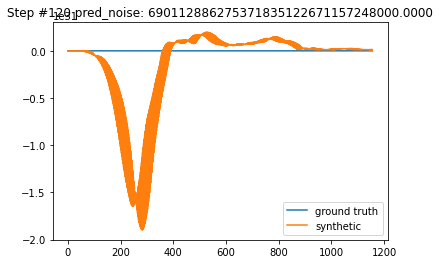

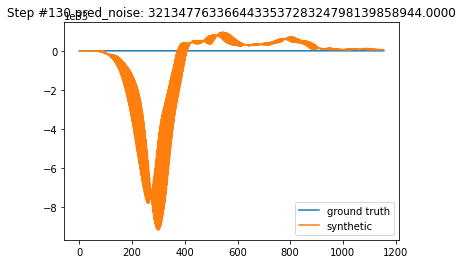

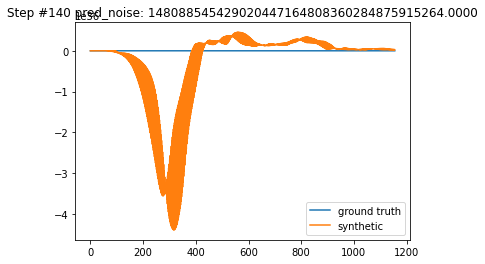

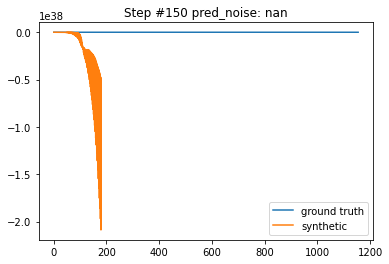

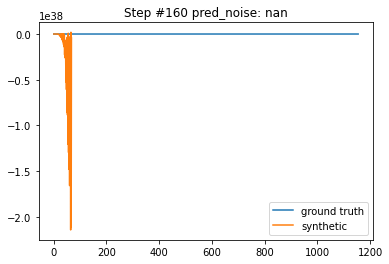

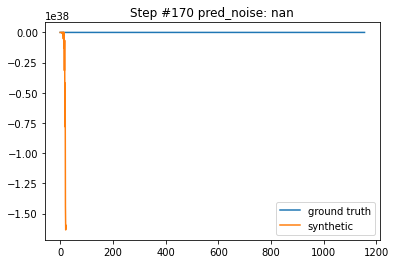

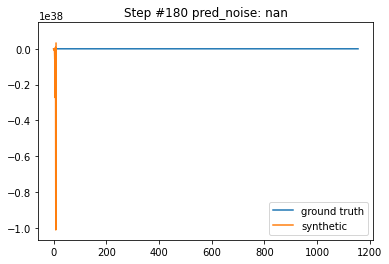

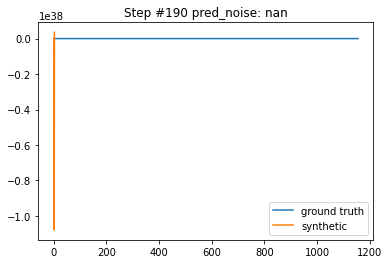

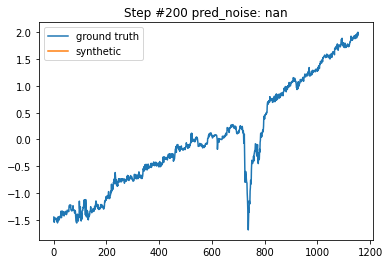

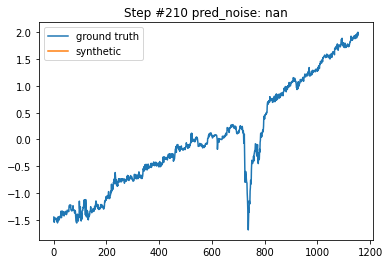

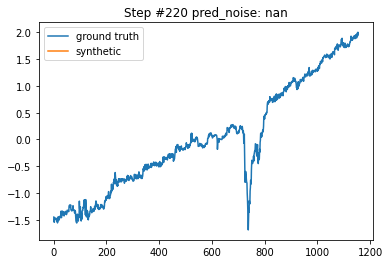

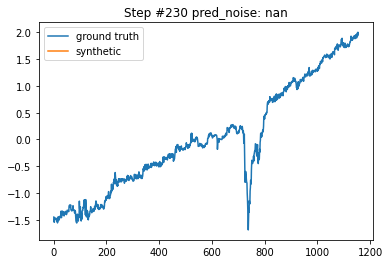

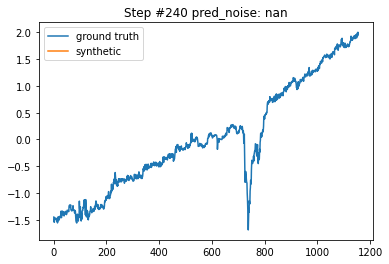

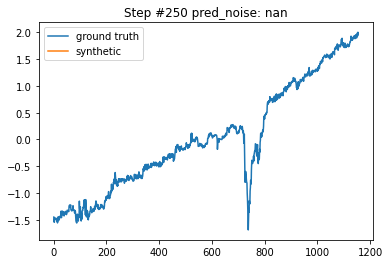

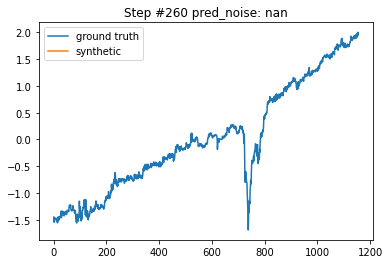

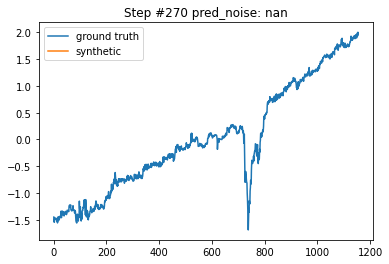

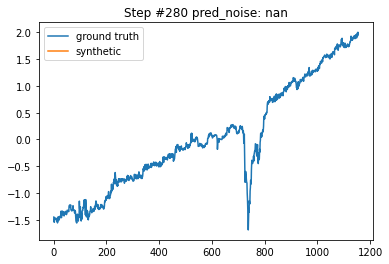

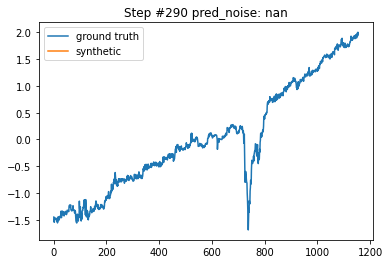

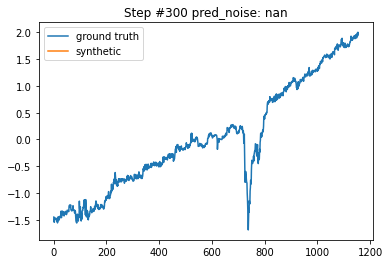

In [31]:
steps = steps_per_epoch * 3
plot_rate = steps_per_epoch // 10
with torch.no_grad():
    model.eval()
    noise = torch.rand(1, 1, len(train)).to(device)
    generated = noise
    for step in range(1, steps + 1):
        pred_noise = model(generated)
        generated -= pred_noise
        if step % plot_rate == 0:

            result = generated.detach().cpu().squeeze().numpy()
            plt.plot(train)
            plt.plot(result)
            plt.legend(["ground truth", "synthetic"])
            plt.title(f"Step #{step} pred_noise: {pred_noise.sum().item():0.4f}")
            plt.show()
# plt.plot(noise.cpu().numpy().squeeze())
# plt.plot(pred_noise.cpu().numpy().squeeze())
# plt.legend(["noise", "pred_noise"])